# Réseau de neurones: les bases en numpy


Le but de ce TP1 est d'acquérir les bases nécessaires à la compréhension des réseaux de neurones à partir d'un modèle simple de type Softmax. La tâche d'apprentissage consiste à classifier les images (28 par 28 pixels) de la base MNIST (http://yann.lecun.com/exdb/mnist/) en 10 catégories représentant les chiffres 0-9.

Le TP2 consistera à généraliser les concepts de ce TP1 à un réseau de neurones multi-couches.

## Téléchargement de la base d'entraînement

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

mnistfile="mnist.pkl.gz"

# If you need to download it : 
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

## Chargement de la base en mémoire

In [2]:
import dataset_loader
train_set, valid_set, test_set = dataset_loader.load_mnist(mnistfile)

Vous pouvez visualiser les différents caractères en changeant l'identifiant de l'image

label: 5


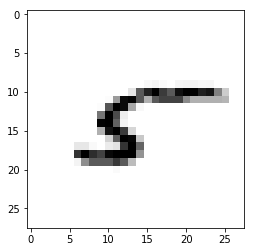

In [3]:
img_id = 900
plt.imshow(train_set[0][img_id].reshape(28,28),cmap='Greys')
print("label: " + str(train_set[1][img_id]))

**Question:** Donner les caractéristiques de la base d'apprentissage train_set

In [4]:
def getDimDataset(train_set):
    n_training =len(train_set[0])
    n_feature = len(train_set[0][0])
    n_label = len(set(train_set[1]))
    return n_training, n_feature, n_label

In [5]:
getDimDataset(train_set)

(50000, 784, 10)

## Création du modèle

Nous allons d'abord créer une couche linéaire, soit une transformation linéaire. La vraie difficulté réside dans la manipulation de matrices de ne pas se mélanger dans les dimensions. 

Pour l'implémentation, nous allons considérer explicitement le terme de biais. Ainsi, une couche linéaire se définit comme la tranformation linéaire: 
$$
\mathbf{y} = \mathbf{W}\mathbf{x}+ \mathbf{b}
$$

Notons *n_in* et *n_out* respectivement les dimensions de $\mathbf{x}$ et $\mathbf{y}$. 

**Questions:**
- écrire les dimensions de W et b
- Coder la fonction d'init. suivante, l'init. est aléatoire et gaussienne, comme dans le cours. La fonction retourne W et b. 


In [6]:
def init(n_in,n_out):
    W = np.random.normal(0, 1/np.sqrt(n_in), (n_out, n_in))
    b = np.random.normal(0, 1/np.sqrt(n_in), (n_out, 1))
    return W,b

**Test:** Même si cela ne sera pas redit, on vérifie toujours les dimensions de ce que l'on crée, et transforme. Dit autrement on fait des tests intermédiaires. En machine learning, comme en programmation, c'est incontournable. 
Pour cela créer, une couche de tailles d'entrée et de sortie égales à 5 et 3. 


In [7]:
n=init(5,3)
n

(array([[ 0.2577955 , -0.41016647, -0.40054842,  0.51035496,  0.13055124],
        [-0.61858117,  0.16144952,  0.52923786, -0.5068859 , -0.16788752],
        [-0.24636775, -0.85684466, -0.29560057, -0.07230365,  0.55960397]]),
 array([[ 0.05772846],
        [ 0.15923661],
        [-0.33854139]]))

**Question :** Donner les dimensions de W et b ainsi que le nombre total de paramètres du modèle

In [8]:
def printInfo(W,b):
    print("W dimensions: " + str(W.shape))
    print("b dimensions: " + str(b.shape))
    print("Number of parameters: " + str(np.size(W) + np.size(b)))

In [9]:
printInfo(n[0],n[1])

W dimensions: (3, 5)
b dimensions: (3, 1)
Number of parameters: 18


**Question:** Implémenter la fonction forward tel que $$y_j = \sum_{i \rightarrow j} W_{ij} x_i + b_j$$ où $x_i$ est un pixel de l'image, $W_{ij}$ est la valeur associée à l'arête reliant les unités $i$ et $j$ et $b_j$ est le biais associé à l'unité $j$

In [10]:
def forward(W,b,X):
    """
        Perform the forward propagation
        :param W: the weights (n_output x n_input)
        :param b: the bias (n_output * 1)
        :param X: the input (minibatch_size x n_input)
        :type W: ndarray
        :type B: ndarray
        :type X: ndarray
        :return: the transformed values (n_output x minibatch_size)
        :rtype: ndarray
    """
    return np.dot(W, X.T) + b

**Question:** Implémenter la fonction softmax $$ \sigma_i = \frac{\exp{a_i}}{\sum_k \exp{a_k}}$$

In [11]:
def softmax(z):
    """
        Perform the softmax transformation to the pre-activation values
        :param a: the pre-activation values
        :type a: ndarray
        :return: the activation values
        :rtype: ndarray
    """
    a=np.max(z)
    #print(a)
    s=0
    for i in z:
        s+=np.exp(i-a)
    z = [np.exp(i-a)/s for i in z]
    return np.array(z)

**Question:** Vérifier que votre implémentation de softmax soit numériquement stable 

In [12]:
# Example for testing the numerical stability of softmax
# It should return [1., 0. ,0.], not [nan, 0., 0.]
z = [10000,1,100]
print(softmax(z))

[1. 0. 0.]


**Question:** Si le softmax s'avère instable, comment le rendre stable ? Proposer une implémentation stable du softmax. 

**Question:** Implémenter le calcul du gradient de l'erreur par rapport à $a_i$:
$$\delta a_i = \sigma_i - 1_{i=l}$$
où $l$ est l'étiquette associée à la donnée courante.

In [13]:
def gradient_out(out, one_hot_batch):
    """
    compute the gradient w.r.t. the pre-activation values of the softmax z_i
    :param out: the softmax values (n_output x minibatch_size)
    :type out: ndarray
    :param one_hot_batch: the one-hot representation of the labels (n_output x minibatch_size)
    :type one_hot_batch: ndarray
    :return: the gradient w.r.t. z (n_output x minibatch_size)
    :rtype: ndarray
    """
    return out - one_hot_batch

**Question:** Implémenter la fonction du calcul de gradient par rapport aux paramètres: $$\delta W_{ij} = \delta a_j x_i$$  $$\delta b_{j} = \delta a_j$$ où $\delta W_{ij}$ est la composante du gradient associée à l'arête reliant les unités $i$ et $j$, $\delta b_{j}$ est la composante du gradient associée au bias de l'unité $j$, $\delta z_j$ est le gradient de l'erreur par rapport à l'unité $j$ et $x_i$ est la valeur d'activation de l'unité $i$.

In [14]:
def gradient(derror, X):
    """
        Compute the gradient w.r.t. the parameters
        :param derror: the gradient w.r.t. z (n_output x minibatch_size)
        :param X: the input (minibatch_size x n_input)
        :type derror: ndarray
        :type minibatch: ndarray
        :return: the gradient w.r.t. the parameters (n_output x n_input), (n_output, 1)
        :rtype: ndarray, ndarray
    """
    minibatch_size = X.shape[0]
    n_out = derror.shape[0]
    n_in = X.shape[1]
    grad_w = np.zeros((n_out, n_in))
    grad_b = np.zeros((n_out, 1))
    
    for i in range(minibatch_size):
        grad_b += np.atleast_2d(derror[:, i]).T
        grad_w += np.outer(derror[:, i], X[i, :])
    
    grad_b /= minibatch_size
    grad_w /= minibatch_size

    return grad_w,grad_b

**Question:** Implémenter la fonction de mise à jour des paramètres $$\theta = \theta - \eta \delta \theta$$ où $\theta$ est un paramètre du modèle et $\delta \theta$ la composante du gradient associée à $\theta$.

In [15]:
def update(eta, W, b, grad_w, grad_b):
    """
        Update the parameters with an update rule
        :param eta: the step-size
        :param W: the weights
        :param b: the bias
        :param grad_w: the gradient w.r.t. the weights
        :param grad_b: the gradient w.r.t. the bias
        :type eta: float
        :type W: ndarray
        :type b: ndarray
        :type grad_w: ndarray
        :type grad_b: ndarray
        :return: the updated parameters
        :rtype: ndarray, ndarray
    """
    W = W - eta * grad_w
    b = b - eta * grad_b
    return W, b

## Algorithme d'apprentissage 

On a tout ce qu'il faut pour mettre en oeuvre l'apprentissage d'un modèle simple. Le modèle est simplement une couche neuronale de sortie, sans couche cachée. 

L'algorithme se déroule en 2 temps, tout d'abord la préparation: 
- init. du modèle
- préparation des données et des variables permettant de stocker l'historique d'apprentissage
- init. des paramètres de la SGD
- définir le nombre d'époque comme une variable

Puis vient la boucle d'apprentissage qui pour chaque époque effectue pour chaque exemple d'apprentissage : 
- inférence du modèle sur l'exemple d'apprentissage 
- calcul de la contribution de l'exemple à la  fonction objectif, et également au taux d'erreur de classification
- Calcul du gradient de sortie
- Mise à jour du modèle

**Question:** Implémenter l'apprentissage du modèle

In [16]:
def one_hot_labels(labels, n_labels):
    one_hot=np.zeros((n_labels, labels.size))
    one_hot[labels, np.arange(labels.size)]=1 # tres utile
    return one_hot

In [17]:
def error_rate(outputs, y):
    n_labels = y.shape[0]
    n_samples = y.shape[1]
    p_y = np.zeros(y.shape)
    p_y[np.argmax(outputs, axis=0), np.arange(n_samples)] = 1
    n_correct = np.sum(p_y * y)
    return 1 - n_correct / n_samples

In [18]:
def log_loss(outputs, y):
    return -np.sum(np.log(outputs)*y)/outputs.shape[1]

In [19]:
def train_nnet(train_set, valid_set=[], nb_epoch=3, minibatch_size=128, eta=1):

    n_training, n_feature, n_label = getDimDataset(train_set)
    W, b = init(n_feature, n_label)
    iteration_counter = 0
    logloss_train = []
    error_train = []
    logloss_valid = []
    error_valid = []

    for i_epoch in range(nb_epoch):
        print("Training model (epoch = {}/{})".format(i_epoch+1, nb_epoch))
        a=forward(W,b,train_set[0])
        outputs_train = softmax(a)
        labels_train = one_hot_labels(train_set[1], 10)
        logloss_train.append(log_loss(outputs_train, labels_train))
        error_train.append(error_rate(outputs_train, labels_train))
        print(" - classification error rate for training = {:.2f}%".format(error_rate(outputs_train, labels_train) * 100))
        if valid_set:
                outputs_valid = softmax(forward(W, b, valid_set[0]))
                labels_valid = one_hot_labels(valid_set[1], n_label)
                logloss_valid.append(log_loss(outputs_valid, labels_valid))
                error_valid.append(error_rate(outputs_valid, labels_valid))
        
        for i_batch in range(0, n_training, minibatch_size):
            # update
            iteration_counter += 1
            batches_index = np.arange(i_batch, i_batch + minibatch_size) % n_training
            X = train_set[0][batches_index, :]
            y = train_set[1][batches_index]
            y_one_hot = one_hot_labels(y, n_label)
            outputs = softmax(forward(W, b, X))
            grad_z = gradient_out(outputs, y_one_hot)
            grad_w, grad_b = gradient(grad_z, X)
            W, b = update(eta, W, b, grad_w, grad_b)

    return W, b, logloss_train, error_train, logloss_valid, error_valid


In [20]:
W, b, logloss_train, error_train, logloss_valid, error_valid = train_nnet(train_set, valid_set, 30, 256, 1)

Training model (epoch = 1/30)
 - classification error rate for training = 92.83%
Training model (epoch = 2/30)
 - classification error rate for training = 9.18%
Training model (epoch = 3/30)
 - classification error rate for training = 8.45%
Training model (epoch = 4/30)
 - classification error rate for training = 8.02%
Training model (epoch = 5/30)
 - classification error rate for training = 7.82%
Training model (epoch = 6/30)
 - classification error rate for training = 7.69%
Training model (epoch = 7/30)
 - classification error rate for training = 7.58%
Training model (epoch = 8/30)
 - classification error rate for training = 7.51%
Training model (epoch = 9/30)
 - classification error rate for training = 7.43%
Training model (epoch = 10/30)
 - classification error rate for training = 7.37%
Training model (epoch = 11/30)
 - classification error rate for training = 7.32%
Training model (epoch = 12/30)
 - classification error rate for training = 7.27%
Training model (epoch = 13/30)
 - cl

**Question:** Si vous stockez correctement les informations, vous pouvez tracer l'évolution du taux d'erreur et de la fonction objectif au cours du temps. Cette étape est loin d'être illustrative, elle est indispensable pour vérifier si l'apprentissage se passe bien. 



**Question:** Inclure dans votre code, le calcul du taux d'erreur et de la fonction objectif sur les données de validation (cela doit faire l'objet du fonction à part). Représenter les évolutions également et les comparer avec celles observées sur les données d'apprentissage. 

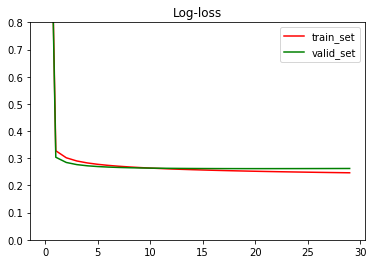

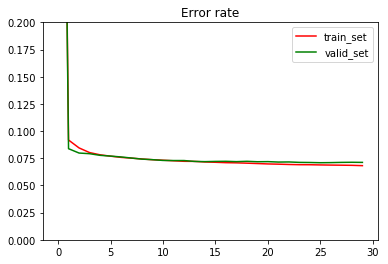

In [21]:
plt.plot(logloss_train, "r", label='train_set')
plt.plot(logloss_valid, "g", label='valid_set')
plt.title("Log-loss")
plt.legend()
plt.ylim((0, 0.8))
plt.show()

plt.plot(error_train, "r", label='train_set')
plt.plot(error_valid, "g", label='valid_set')
plt.title("Error rate")
plt.legend()
plt.ylim((0, 0.2))
plt.show()

In [22]:
outputs_test = softmax(forward(W, b, test_set[0]))
labels_test = one_hot_labels(test_set[1], 10)
print("Test results:")
print("Log-loss = {:.3f}".format(log_loss(outputs_test, labels_test)))
print("Error rate = {:.2f}%".format(error_rate(outputs_test, labels_test) * 100))

Test results:
Log-loss = 0.274
Error rate = 7.67%


**Question:** Montrer, à l'aide d'une figure, l'effet du step-size (prendre $\eta$=[0.01,0.1,1.0,10.]) sur les courbes d'apprentissage

In [23]:
#different step-size  
NB_EPOCH = 30
MINIBATCH_SIZE = 256
eta_list =[0.01, 0.1, 1.0, 10.0]
logloss_train_list = []
error_train_list = []
logloss_valid_list = []
error_valid_list = []

for eta in eta_list:
    print("eta = {}".format(eta))
    W_, b_, logloss_train, error_train, logloss_valid, error_valid = train_nnet(train_set, valid_set, NB_EPOCH, MINIBATCH_SIZE, eta)
    logloss_train_list.append(logloss_train)
    error_train_list.append(error_train)
    logloss_valid_list.append(logloss_valid)
    error_valid_list.append(error_valid)

eta = 0.01
Training model (epoch = 1/30)
 - classification error rate for training = 89.49%
Training model (epoch = 2/30)
 - classification error rate for training = 22.10%
Training model (epoch = 3/30)
 - classification error rate for training = 17.76%
Training model (epoch = 4/30)
 - classification error rate for training = 16.14%
Training model (epoch = 5/30)
 - classification error rate for training = 15.14%
Training model (epoch = 6/30)
 - classification error rate for training = 14.47%
Training model (epoch = 7/30)
 - classification error rate for training = 13.90%
Training model (epoch = 8/30)
 - classification error rate for training = 13.52%
Training model (epoch = 9/30)
 - classification error rate for training = 13.17%
Training model (epoch = 10/30)
 - classification error rate for training = 12.92%
Training model (epoch = 11/30)
 - classification error rate for training = 12.70%
Training model (epoch = 12/30)
 - classification error rate for training = 12.45%
Training model

Training model (epoch = 12/30)
 - classification error rate for training = 9.22%
Training model (epoch = 13/30)
 - classification error rate for training = 9.59%
Training model (epoch = 14/30)
 - classification error rate for training = 8.86%
Training model (epoch = 15/30)
 - classification error rate for training = 35.88%
Training model (epoch = 16/30)
 - classification error rate for training = 9.36%
Training model (epoch = 17/30)
 - classification error rate for training = 8.82%
Training model (epoch = 18/30)
 - classification error rate for training = 8.73%
Training model (epoch = 19/30)
 - classification error rate for training = 10.37%
Training model (epoch = 20/30)
 - classification error rate for training = 9.51%
Training model (epoch = 21/30)
 - classification error rate for training = 24.34%
Training model (epoch = 22/30)
 - classification error rate for training = 10.50%
Training model (epoch = 23/30)
 - classification error rate for training = 8.44%
Training model (epoch = 

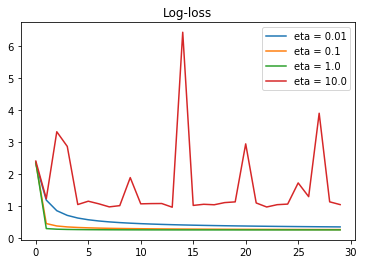

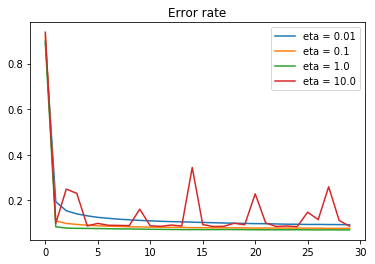

In [24]:
#Log-loss and error rate for valide set
for i in range(len(logloss_valid_list)):
    plt.plot(logloss_valid_list[i], label="eta = " + str(eta_list[i]))
plt.title("Log-loss")
plt.legend()
plt.show()

for i in range(len(error_valid_list)):
    plt.plot(error_valid_list[i], label="eta = " + str(eta_list[i]))
plt.title("Error rate")
plt.legend()
plt.show()